In [1]:
# Aggregate Word Embeddings

import json
import numpy as np
import pandas as pd
from tqdm import tqdm

# List the file parts (update filenames if necessary)
file_parts = [
    "D:/PHD/Data Science/txt/normalized_verses_with_embeddings_context_part1.json",
    "D:/PHD/Data Science/txt/normalized_verses_with_embeddings_context_part2.json",
    "D:/PHD/Data Science/txt/normalized_verses_with_embeddings_context_part3.json",
    "D:/PHD/Data Science/txt/normalized_verses_with_embeddings_context_part4.json",
    "D:/PHD/Data Science/txt/normalized_verses_with_embeddings_context_part5.json"
]

# Load all verses from the 5 parts with a progress bar
all_verses = []
for file_name in tqdm(file_parts, desc="Loading file parts"):
    with open(file_name, "r", encoding="utf-8") as f:
        verses = json.load(f)
        all_verses.extend(verses)
print(f"📥 Loaded {len(all_verses)} verses from {len(file_parts)} files.")

# Remove duplicates: keep only one entry per (surah, verse)
unique_verses_dict = {}
for verse in all_verses:
    key = (verse["surah"], verse["verse"])
    unique_verses_dict[key] = verse  # Overwrites duplicates if any
unique_verses = list(unique_verses_dict.values())
print(f"✅ After deduplication, {len(unique_verses)} unique verses remain.")

# Aggregate token embeddings to create a verse embedding (using average pooling) with progress bar
verse_embeddings = []
verse_meta = []
for verse in tqdm(unique_verses, desc="Processing verses"):
    token_embeds = verse.get("token_embeddings", [])
    if token_embeds:
        token_embeds = np.array(token_embeds)
        aggregated = np.mean(token_embeds, axis=0)
    else:
        aggregated = np.zeros(300)  # Adjust the dimension if needed
    verse_embeddings.append(aggregated)
    verse_meta.append({
        "surah": verse["surah"],
        "verse": verse["verse"],
        "text": verse["text"]
    })

print(f"✅ Computed verse embeddings for {len(verse_embeddings)} unique verses.")

# Save the aggregated embeddings in a compact binary format
embeddings_array = np.array(verse_embeddings)
np.save("output/aggregated/quran_verse_aggregated_embeddings.npy", embeddings_array)
print("💾 Aggregated embeddings saved to 'quran_verse_aggregated_embeddings.npy'.")

# Save only the metadata in a CSV file (without the huge embedding vectors)
df_meta = pd.DataFrame(verse_meta)
df_meta.to_csv("output/aggregated/quran_verse_aggregated_metadata.csv", index=False)
print("💾 Metadata saved to 'quran_verse_aggregated_metadata.csv'.")


Loading file parts: 100%|████████████████████████████████████████████████████████████████| 5/5 [01:13<00:00, 14.69s/it]


📥 Loaded 7795 verses from 5 files.
✅ After deduplication, 6236 unique verses remain.


Processing verses: 100%|█████████████████████████████████████████████████████████| 6236/6236 [00:03<00:00, 1767.84it/s]


✅ Computed verse embeddings for 6236 unique verses.
💾 Aggregated embeddings saved to 'quran_verse_embeddings.npy'.
💾 Metadata saved to 'quran_verse_aggregated_metadata.csv'.


In [2]:
# Root Configuration
specific_root = "صلح"

In [5]:
# Extract Verse Embedding

import json
import torch
import pandas as pd
import numpy as np

# Load the aggregated verse embeddings
print("📥 Loading verse embeddings from 'quran_verse_aggregated_embeddings.npy'...")
embeddings_array = np.load("output/aggregated/quran_verse_aggregated_embeddings.npy")
print(f"✅ Loaded embeddings with shape: {embeddings_array.shape}")

# Load the corresponding metadata
print("📥 Loading metadata from 'quran_verse_aggregated_metadata.csv'...")
verse_df = pd.read_csv("output/aggregated/quran_verse_aggregated_metadata.csv")
print(f"✅ Loaded metadata for {len(verse_df)} verses.")

# Attach the embeddings to the DataFrame
verse_df["embedding"] = list(embeddings_array)

# Load the original Quranic data to retrieve 'arabic_roots'
print("📥 Loading Quranic data from 'unified_quran_data.json'...")
with open("data/unified_quran_data.json", "r", encoding="utf-8") as f:
    quran_data = json.load(f)
print(f"✅ Loaded {len(quran_data)} verses from JSON.")

# Create a DataFrame from the JSON data (keeping relevant fields)
quran_df = pd.DataFrame(quran_data)[['surah', 'verse', 'arabic_roots']]

# Convert merge keys to string to avoid dtype conflicts
verse_df['surah'] = verse_df['surah'].astype(str)
verse_df['verse'] = verse_df['verse'].astype(str)
quran_df['surah'] = quran_df['surah'].astype(str)
quran_df['verse'] = quran_df['verse'].astype(str)

# Merge to add arabic_roots to the embedding data
merged_df = pd.merge(verse_df, quran_df, on=["surah", "verse"], how="left")
print("✅ Merged metadata with Arabic roots.")

# Filter verses that contain the specified root
filtered_df = merged_df[merged_df['arabic_roots'].apply(lambda roots: specific_root in roots if isinstance(roots, list) else False)]
print(f"🔎 Found {len(filtered_df)} verses containing the root '{specific_root}'.")

# Convert filtered embeddings to torch tensor
filtered_embeddings = torch.tensor(filtered_df["embedding"].tolist())
print("✅ Converted filtered embeddings to torch tensor with shape:", filtered_embeddings.shape)

# Save filtered results
output_pickle = f"output/aggregated/{specific_root}_aggregated_filtered_quran_data.pkl"
filtered_df.to_pickle(output_pickle)
print(f"💾 Filtered data saved to '{output_pickle}'.")

output_csv = f"output/aggregated/{specific_root}_aggregated_filtered_quran_data.csv"
filtered_df.to_csv(output_csv, index=False)
print(f"💾 Filtered data saved to '{output_csv}'.")


📥 Loading verse embeddings from 'quran_verse_aggregated_embeddings.npy'...
✅ Loaded embeddings with shape: (6236, 768)
📥 Loading metadata from 'quran_verse_aggregated_metadata.csv'...
✅ Loaded metadata for 6236 verses.
📥 Loading Quranic data from 'unified_quran_data.json'...
✅ Loaded 6236 verses from JSON.
✅ Merged metadata with Arabic roots.
🔎 Found 170 verses containing the root 'صلح'.
✅ Converted filtered embeddings to torch tensor with shape: torch.Size([170, 768])


C:\Users\DiQz\AppData\Local\Temp\ipykernel_23384\422402472.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  filtered_embeddings = torch.tensor(filtered_df["embedding"].tolist())


💾 Filtered data saved to 'output/صلح_aggregated_filtered_quran_data.pkl'.
💾 Filtered data saved to 'output/صلح_aggregated_filtered_quran_data.csv'.


In [6]:
# Dimension Reduction

import umap
import torch
import pandas as pd

# Load the filtered data with metadata and aggregated embeddings
print(f"📥 Loading filtered data from '{specific_root}_aggregated_filtered_quran_data.pkl'...")
filtered_df = pd.read_pickle(f"output/aggregated/{specific_root}_aggregated_filtered_quran_data.pkl")

# Extract embeddings and convert to torch tensor
filtered_embeddings = torch.tensor(filtered_df['embedding'].tolist())
print(f"✅ Loaded {filtered_embeddings.shape[0]} verse embeddings for root '{specific_root}'.")
num_embeddings = filtered_embeddings.shape[0]

# Set default number of dimensions for UMAP reduction
n_components = num_embeddings - 3
print(f"🔻 Reducing dimensions to {n_components} using UMAP...")

# Apply UMAP
umap_model = umap.UMAP(n_neighbors=15, n_components=n_components, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(filtered_embeddings.cpu())
print("✅ UMAP reduction complete. Reduced shape:", reduced_embeddings.shape)

# Store reduced embeddings in the DataFrame
filtered_df['reduced_embedding'] = list(reduced_embeddings)

# Save to file
output_file = f"output/aggregated/{specific_root}_aggregated_filtered_quran_reduced.pkl"
filtered_df.to_pickle(output_file)
print(f"💾 Reduced embeddings and metadata saved to '{output_file}'.")


📥 Loading filtered data from 'صلح_aggregated_filtered_quran_data.pkl'...
✅ Loaded 170 verse embeddings for root 'صلح'.
🔻 Reducing dimensions to 167 using UMAP...


C:\Users\DiQz\anaconda3\envs\quran_analysis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\DiQz\anaconda3\envs\quran_analysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP reduction complete. Reduced shape: (170, 167)
💾 Reduced embeddings and metadata saved to 'output/صلح_aggregated_filtered_quran_reduced.pkl'.


📥 Loading reduced data from 'output/صلح_aggregated_filtered_quran_reduced.pkl'...
✅ Loaded reduced data for 170 verses.
✅ Extracted embeddings array with shape: (170, 167)


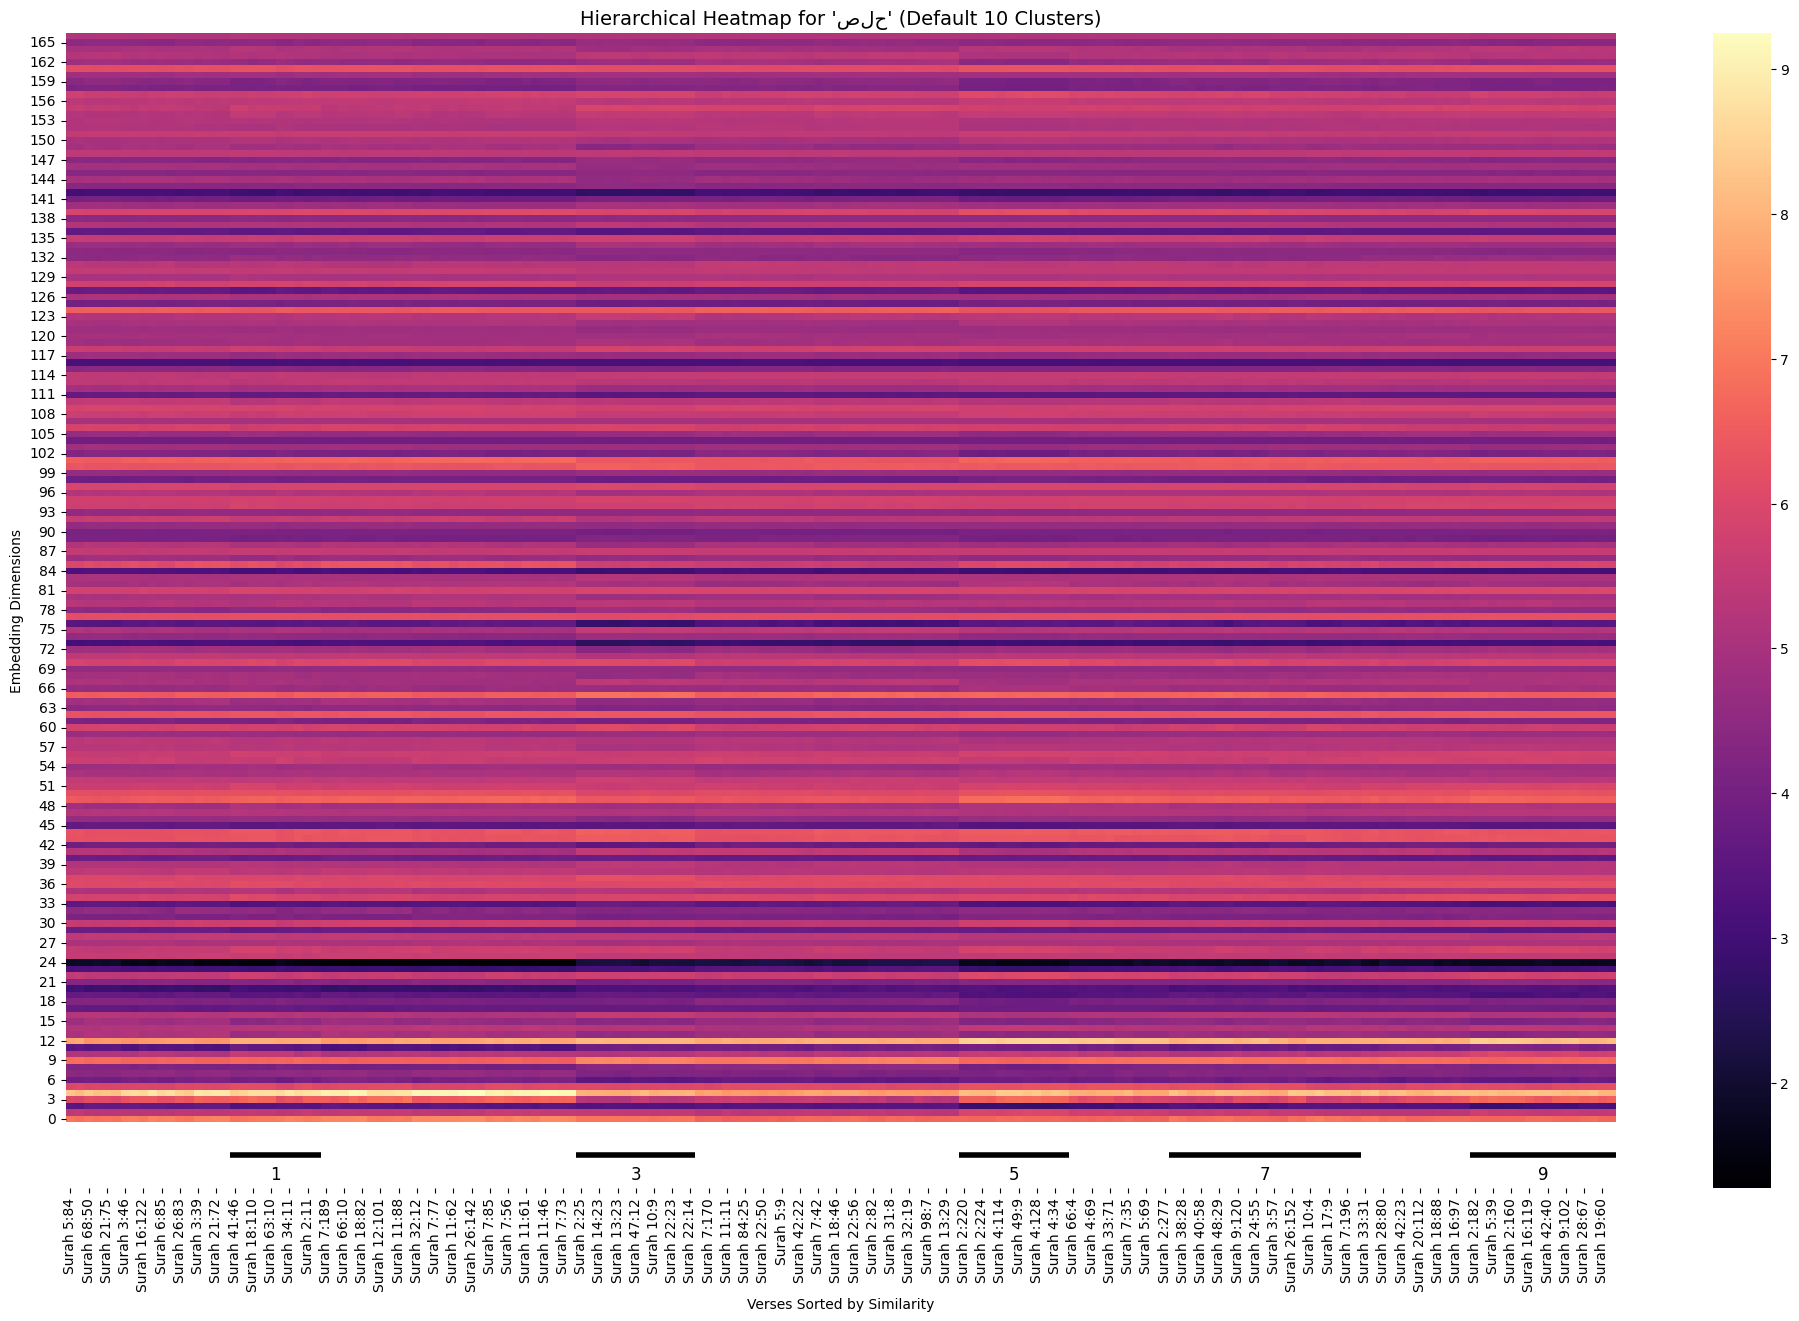

Enter desired number of clusters (press Enter to use default: 10):  20


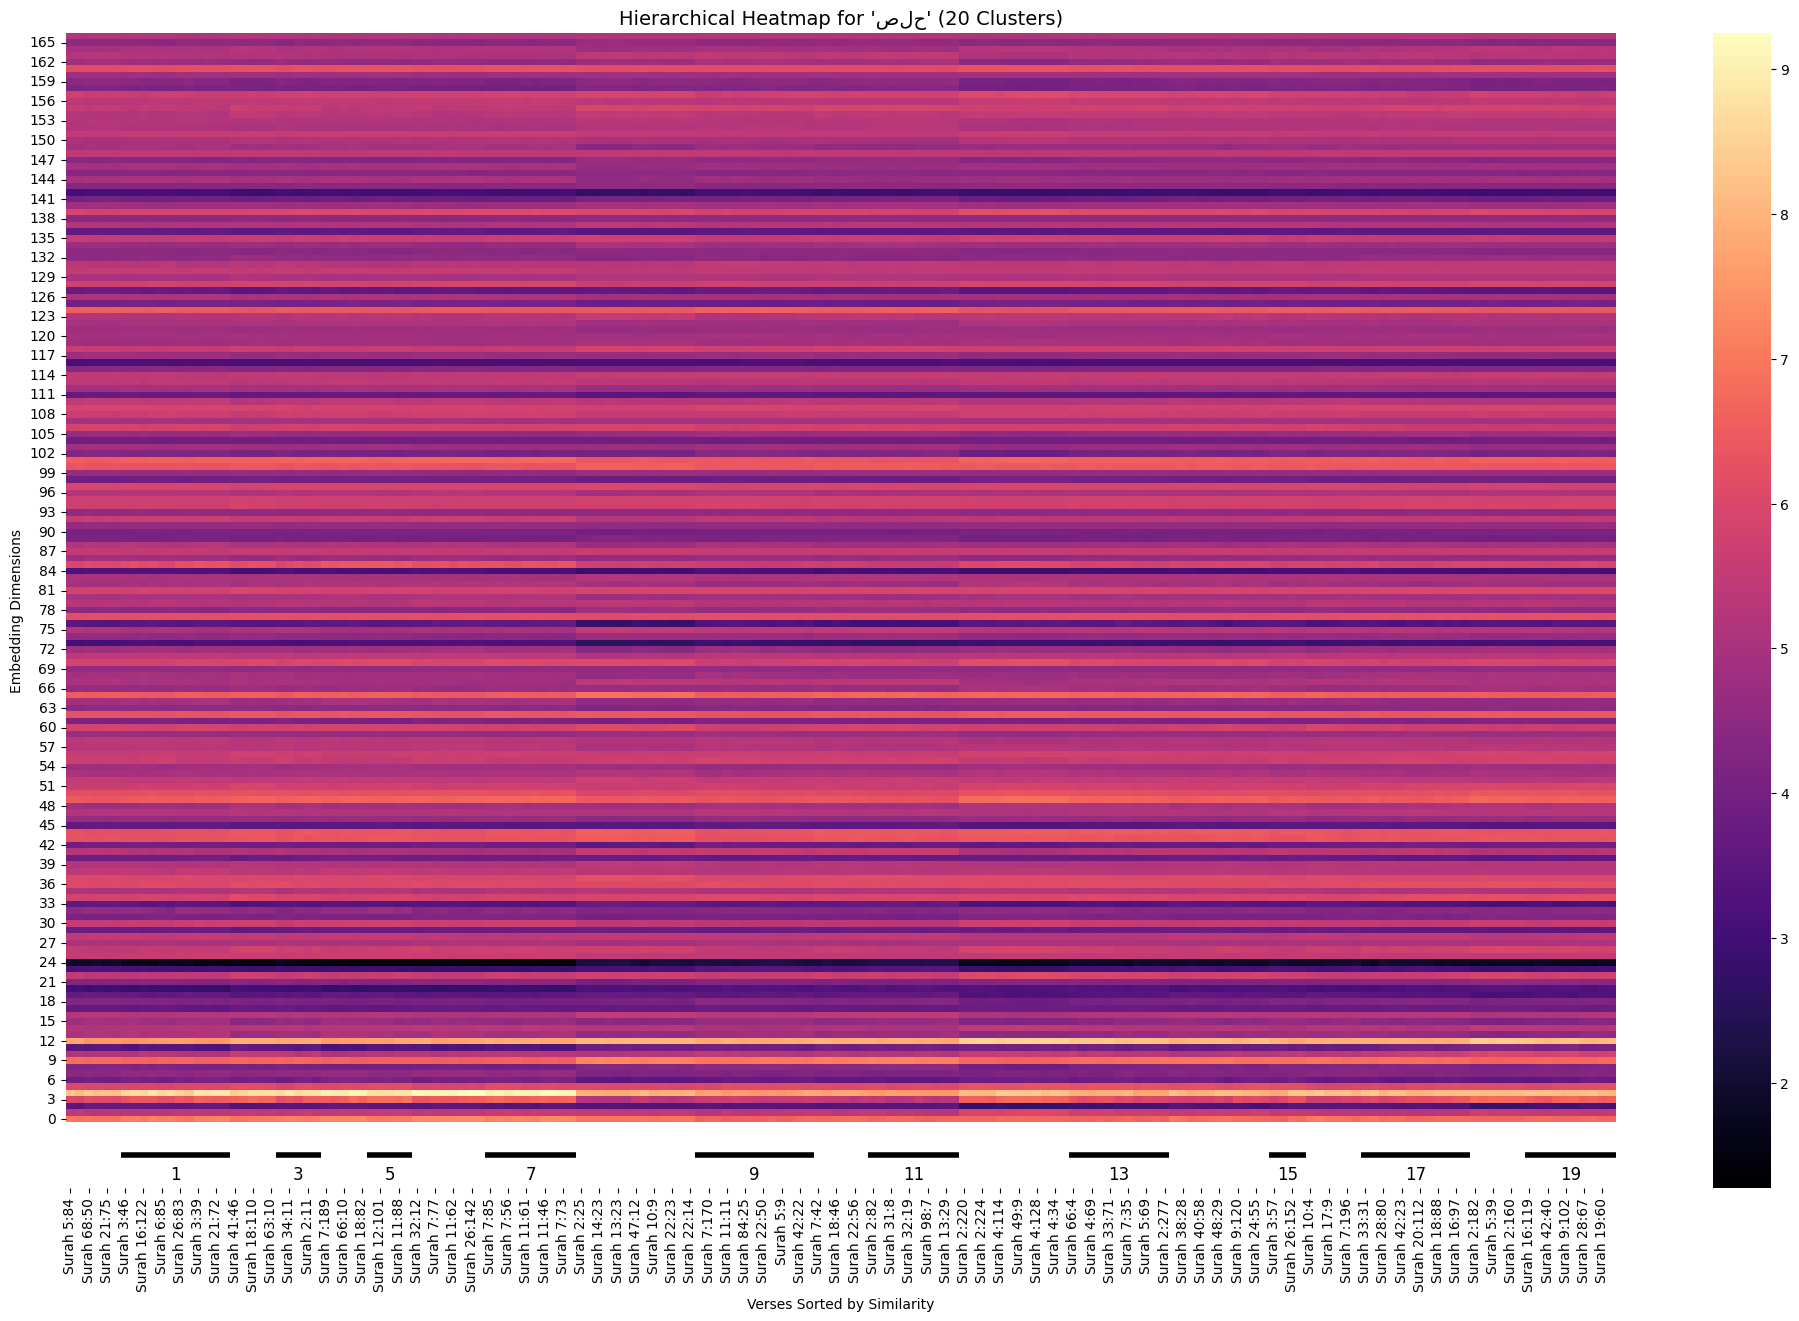

✅ Final heatmap saved to 'output/صلح_aggregated_verses_hierarchical_heatmap.png'.
✅ Saved hierarchical clustering JSON output to 'output/صلح_aggregated_verses_hierarchical_clusters.json'.
✅ Saved human-readable text output to 'output/صلح_aggregated_verses-human_readable_clusters.txt'.


In [7]:
# Clustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.cluster.hierarchy import linkage, fcluster, leaves_list

# --- Config ---
default_clusters = 10
heatmap_output = f"output/aggregated/{specific_root}_aggregated_verses_hierarchical_heatmap.png"
cluster_json_output = f"output/aggregated/{specific_root}_aggregated_verses_hierarchical_clusters.json"
txt_output_file = f"output/aggregated/{specific_root}_aggregated_verses-human_readable_clusters.txt"

# --- Load Reduced Embeddings ---
filtered_reduced_file = f"output/aggregated/{specific_root}_aggregated_filtered_quran_reduced.pkl"
print(f"📥 Loading reduced data from '{filtered_reduced_file}'...")
filtered_df = pd.read_pickle(filtered_reduced_file)
print(f"✅ Loaded reduced data for {len(filtered_df)} verses.")

# Extract reduced embeddings as a NumPy array
embeddings_array = np.array(filtered_df['reduced_embedding'].tolist())
print(f"✅ Extracted embeddings array with shape: {embeddings_array.shape}")

# Create verse labels (e.g., "Surah 1:1")
verse_labels = filtered_df.apply(lambda row: f"Surah {row['surah']}:{row['verse']}", axis=1).tolist()

# --- Hierarchical Clustering ---
linkage_matrix = linkage(embeddings_array, method='ward')
ordered_indices = leaves_list(linkage_matrix)

# Compute default cluster labels
cluster_labels_default = fcluster(linkage_matrix, default_clusters, criterion='maxclust')
sorted_labels_default = cluster_labels_default[ordered_indices]

# --- Reorder for plotting ---
sorted_embeddings = embeddings_array[ordered_indices]
sorted_verse_labels = [verse_labels[i] for i in ordered_indices]

# Prepare heatmap data (transpose so dimensions are rows)
heatmap_data = pd.DataFrame(sorted_embeddings.T, columns=sorted_verse_labels)

# --- Plot initial heatmap with default cluster overlays ---
plt.figure(figsize=(25, 15))
ax = sns.heatmap(heatmap_data, cmap="magma", cbar=True)
ax.set_title(f"Hierarchical Heatmap for '{specific_root}' (Default {default_clusters} Clusters)", fontsize=14)
ax.set_xlabel("Verses Sorted by Similarity")
ax.set_ylabel("Embedding Dimensions")

# Draw default cluster boundary lines
cluster_boundaries = []
prev_label = sorted_labels_default[0]
for i, label in enumerate(sorted_labels_default):
    if label != prev_label:
        cluster_boundaries.append(i)
        prev_label = label
cluster_boundaries.append(len(sorted_verse_labels))

line_colors = ["black", "white"]
for i in range(len(cluster_boundaries) - 1):
    start = cluster_boundaries[i]
    end = cluster_boundaries[i + 1]
    ax.hlines(-5, start, end, colors=line_colors[i % 2], linewidth=4)
    ax.text((start + end) / 2, -8, f"{i+1}", ha="center", va="center", fontsize=12, color=line_colors[i % 2])

ax.set_xlim([0, len(sorted_verse_labels)])
ax.set_ylim([-10, heatmap_data.shape[0]])
plt.show()
plt.close()

# --- Ask user for custom number of clusters ---
user_input = input(f"Enter desired number of clusters (press Enter to use default: {default_clusters}): ")
if user_input.strip() == "":
    final_clusters = default_clusters
else:
    try:
        final_clusters = int(user_input)
    except ValueError:
        print(f"Invalid input. Using default value of {default_clusters}.")
        final_clusters = default_clusters

# --- Final clustering with user-defined number ---
cluster_labels = fcluster(linkage_matrix, final_clusters, criterion='maxclust')
sorted_labels_final = cluster_labels[ordered_indices]

# --- Replot heatmap with updated clusters ---
plt.figure(figsize=(25, 15))
ax = sns.heatmap(heatmap_data, cmap="magma", cbar=True)
ax.set_title(f"Hierarchical Heatmap for '{specific_root}' ({final_clusters} Clusters)", fontsize=14)
ax.set_xlabel("Verses Sorted by Similarity")
ax.set_ylabel("Embedding Dimensions")

# Updated cluster boundaries
cluster_boundaries = []
prev_label = sorted_labels_final[0]
for i, label in enumerate(sorted_labels_final):
    if label != prev_label:
        cluster_boundaries.append(i)
        prev_label = label
cluster_boundaries.append(len(sorted_verse_labels))

for i in range(len(cluster_boundaries) - 1):
    start = cluster_boundaries[i]
    end = cluster_boundaries[i + 1]
    ax.hlines(-5, start, end, colors=line_colors[i % 2], linewidth=4)
    ax.text((start + end) / 2, -8, f"{i+1}", ha="center", va="center", fontsize=12, color=line_colors[i % 2])

ax.set_xlim([0, len(sorted_verse_labels)])
ax.set_ylim([-10, heatmap_data.shape[0]])
plt.savefig(heatmap_output, dpi=600, bbox_inches="tight")
plt.show()
plt.close()
print(f"✅ Final heatmap saved to '{heatmap_output}'.")

# --- Save cluster assignments: JSON ---
sorted_df = filtered_df.iloc[ordered_indices].copy()
sorted_df['cluster'] = sorted_labels_final

clusters_dict = {}
for cluster in sorted(set(sorted_labels_final)):
    clusters_dict[f"Cluster {cluster}"] = []
    cluster_rows = sorted_df[sorted_df['cluster'] == cluster]
    for _, row in cluster_rows.iterrows():
        clusters_dict[f"Cluster {cluster}"].append({
            "surah": row['surah'],
            "verse": row['verse'],
            "text": row['text']
        })

with open(cluster_json_output, "w", encoding="utf-8") as f:
    json.dump(clusters_dict, f, ensure_ascii=False, indent=4)
print(f"✅ Saved hierarchical clustering JSON output to '{cluster_json_output}'.")

# --- Save cluster assignments: Plain Text ---
with open(txt_output_file, "w", encoding="utf-8") as f:
    for cluster in sorted(set(sorted_labels_final)):
        f.write(f"Cluster {cluster}:\n")
        cluster_rows = sorted_df[sorted_df['cluster'] == cluster]
        for _, row in cluster_rows.iterrows():
            line = json.dumps({
                "surah": row['surah'],
                "verse": row['verse'],
                "text": row['text']
            }, ensure_ascii=False)
            f.write(line + "\n")
        f.write("\n")
print(f"✅ Saved human-readable text output to '{txt_output_file}'.")
